In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn


In [3]:
data = pd.read_csv('/creditcard.csv')

In [5]:
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [6]:
data.shape

(15936, 31)

In [7]:
# random_state helps assure that you always get the same output when you split the data
# this helps create reproducible results and it does not actually matter what the number is
# frac is percentage of the data that will be returned
data = data.sample(frac = 0.2, random_state = 1)
print(data.shape)

(3187, 31)


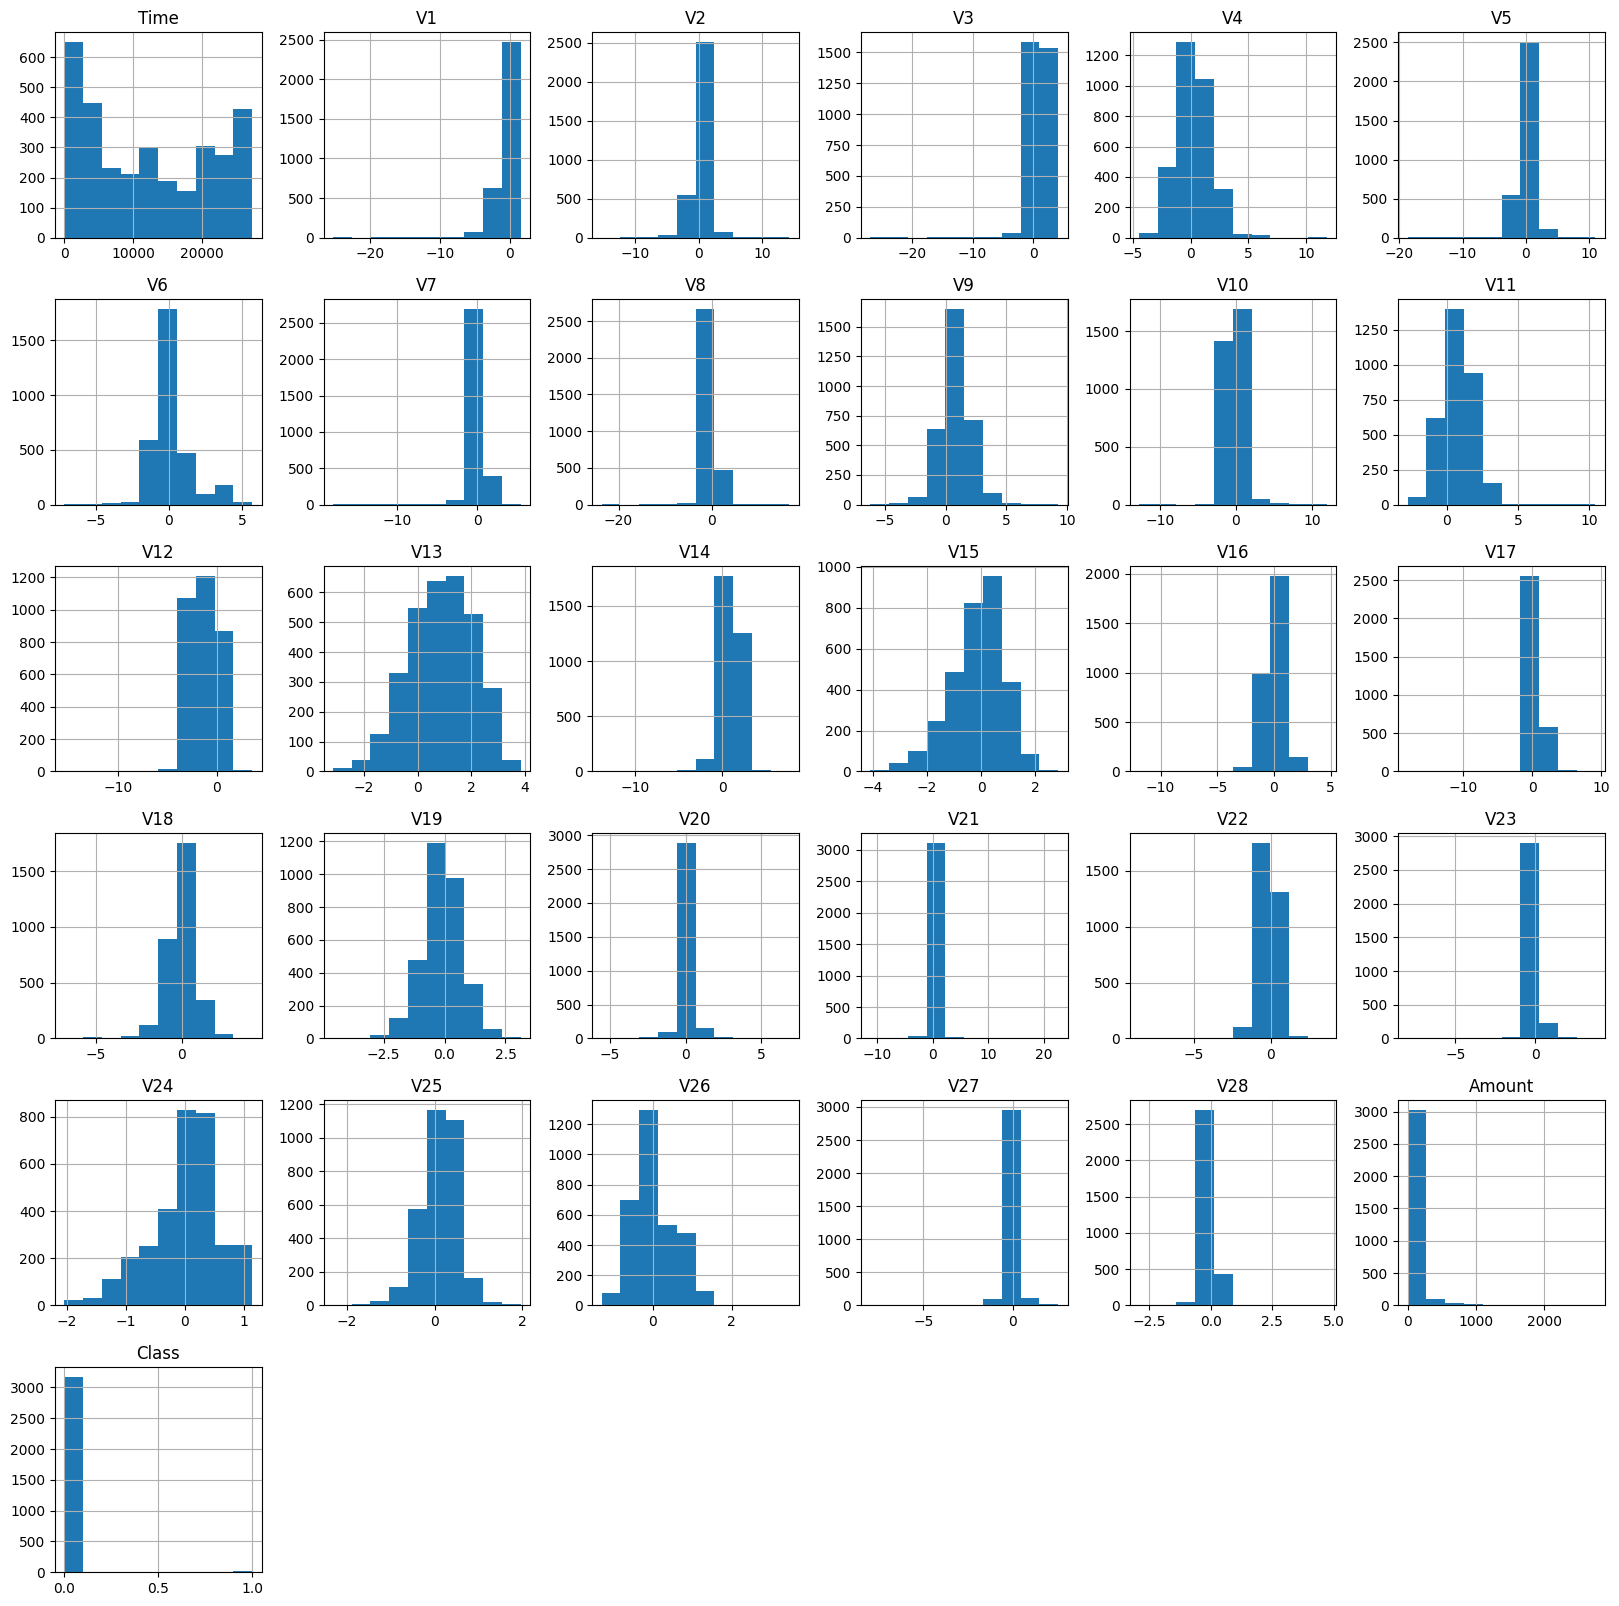

In [8]:
# plot the histogram of each parameter
data.hist(figsize = (20, 20))
plt.show()

In [9]:
# determine the number of fraud cases
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

outlier_fraction = len(fraud) / float(len(valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))

0.004095778197857593
Fraud Cases: 13
Valid Cases: 3174


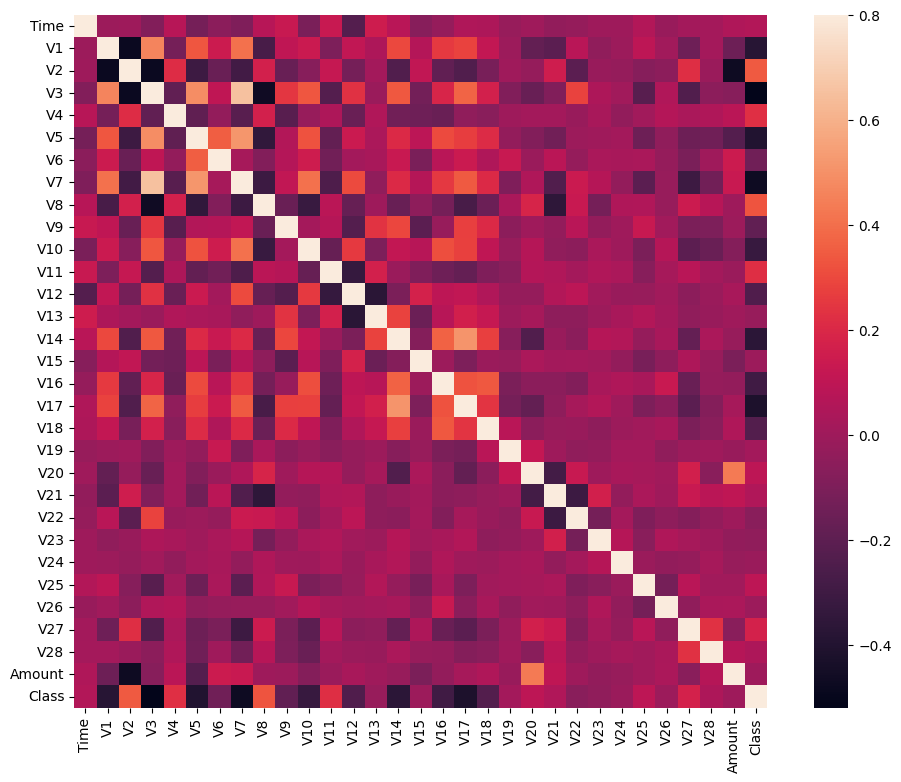

In [10]:
# correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [13]:
# get the columns from the dataframe
columns = data.columns.tolist()

# filter the columns to remove the data we do not want
columns = [c for c in columns if c not in ['Class']]

# store the variable we will be predicting on which is class
target = 'Class'

# X includes everything except our class column
X = data[columns]
# Y includes all the class labels for each sample
# this is also one-dimensional
Y = data[target]

# print the shapes of X and Y
print(X.shape)
print(Y.shape)


(3187, 30)
(3187,)


**Applying Algorithms**

In [14]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [15]:
# define a random state
state = 1

# define the outlier detection methods
classifiers = {
    # contamination is the number of outliers we think there are
    'Isolation Forest': IsolationForest(max_samples = len(X),
                                       contamination = outlier_fraction,
                                       random_state = state),
    # number of neighbors to consider, the higher the percentage of outliers the higher you want to make this number
    'Local Outlier Factor': LocalOutlierFactor(
    n_neighbors = 20,
    contamination = outlier_fraction)
}

In [17]:
n_outliers = len(fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):

    # fit the data and tag outliers
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)

    # reshape the prediction values to 0 for valid and 1 for fraud
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
     # calculate the number of errors
    n_errors = (y_pred != Y).sum()

    # classification matrix
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 11
0.9965484781926577
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3174
         1.0       0.57      0.62      0.59        13

    accuracy                           1.00      3187
   macro avg       0.78      0.81      0.80      3187
weighted avg       1.00      1.00      1.00      3187

Local Outlier Factor: 27
0.9915280828365234
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3174
         1.0       0.00      0.00      0.00        13

    accuracy                           0.99      3187
   macro avg       0.50      0.50      0.50      3187
weighted avg       0.99      0.99      0.99      3187



Looking at precision for fraudulent cases (1) lets us know the percentage of cases that are getting correctly labeled. 'Precision' accounts for false-positives. 'Recall' accounts for false-negatives. Low numbers could mean that we are constantly calling clients asking them if they actually made the transaction which could be annoying.

Goal: To get better percentages.

Our Isolation Forest method (which is Random Forest based) was able to produce a better result. Looking at the f1-score 26% (or approx. 30%) of the time we are going to detect the fraudulent transactions.
